## **Detecting which US Presidential Nominee said it ?** 
### Text Classification of quotes from candidates vying to be the Democratic presidential nominee for the 2020 US presidential election.


Here, all data has been extracted from debates between candidates. We will build a NLP classification model to identify who said what for a subset of unlabeled data.

**The quotes are. subjected to basic text processing steps as follows** - 

1. Stopword removal
2. Punctuation removal
3. Lemmatization
4. Tokenization using unigram

To prepare data for modeling, I performed feature engineering. Here, I engineered features which utilize count of various components of the text such as character, word, punctuation etc. 

**The text classification is done using Supervised & Semi-Supervised techniques.**

The following models were explored:
1. Regularized Logistic Regression
2. Random Forest
3. XGBoost

In [1]:
import numpy as np
import pandas as pd
import re
from scipy.sparse import hstack
import string

In [2]:
from os import listdir
from os.path import isfile, join

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import xgboost as xgb
import sklearn
from sklearn import model_selection, preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [5]:
from sklearn.ensemble import RandomForestClassifier

import nltk
from nltk.tokenize import WhitespaceTokenizer 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

**Initial Steps**

Loading training and testing datasets into a pandas dataframe. 

In [42]:
# Defining the directory path 
dir_path = "/Users/rohan20k/Desktop/NLP Project/data/raw"

In [217]:
def create_text_list(dir_path,test_or_train):
    name_list = []
    text_list = []
    train_text_label = []
    # Initiating file list for looping
    full_path = dir_path+'/'+test_or_train
    file_list = [file for file in listdir(full_path) if isfile(full_path+'/'+file)]
    if test_or_train == "train":
        for file in file_list:
            file_open = open(full_path+'/'+file, 'r')
            name_list.append(file.split('_')[0])
            text = file_open.readlines()
            text_list.append(text)
        print(f"Successfully read {len(text_list)} files into a the list")
        return name_list,text_list
    else: 
        for file in file_list:
            file_open = open(full_path+'/'+file, 'r')
            name_list.append(file)
            text = file_open.readlines()
            text_list.append(text)
        print(f"Successfully read {len(text_list)} files into a the list")
        return name_list,text_list

In [123]:
### Loading Training Data

training_label, training_text = create_text_list(dir_path,'train')

Successfully read 528 files into a the list


#### Taking a look at the unique label names in the training data

In [127]:
list(set(training_label))

['Booker',
 'Yang',
 'Sanders',
 'Gabbard',
 "O'Rourke",
 'Biden',
 'Klobuchar',
 'Warren',
 'Buttigieg',
 'Harris',
 'Steyer',
 'Castro']

In [225]:
name, text = create_text_list(dir_path,'train')

Successfully read 528 files into a the list


In [226]:
### Capiltalising all the label names and removing any punctuation in label names. 
name = [x.upper().replace("'", "") for x in name]

In [227]:
text = [x[0] for x in text]

In [235]:
text_1 = [':'.join(x.split(":")[1:]) for x in text]
text_2 = [x.split(":")[0].split(" ")[1].upper().replace("'","") for x in text ]

In [236]:
text_2

['HARRIS',
 'HARRIS',
 'HARRIS',
 'WARREN',
 'WARREN',
 'HARRIS',
 'BUTTIGIEG',
 'BOOKER',
 'KLOBUCHAR',
 'BUTTIGIEG',
 'BOOKER',
 'SANDERS',
 'GABBARD',
 'BIDEN',
 'BIDEN',
 'STEYER',
 'STEYER',
 'BIDEN',
 'BUTTIGIEG',
 'BIDEN',
 'GABBARD',
 'SANDERS',
 'BOOKER',
 'KLOBUCHAR',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'BOOKER',
 'HARRIS',
 'WARREN',
 'WARREN',
 'HARRIS',
 'HARRIS',
 'WARREN',
 'HARRIS',
 'HARRIS',
 'HARRIS',
 'WARREN',
 'WARREN',
 'WARREN',
 'HARRIS',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'BOOKER',
 'SANDERS',
 'GABBARD',
 'SANDERS',
 'BUTTIGIEG',
 'BIDEN',
 'BIDEN',
 'BIDEN',
 'BUTTIGIEG',
 'BIDEN',
 'SANDERS',
 'GABBARD',
 'SANDERS',
 'BOOKER',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'HARRIS',
 'WARREN',
 'WARREN',
 'WARREN',
 'HARRIS',
 'HARRIS',
 'HARRIS',
 'HARRIS',
 'WARREN',
 'WARREN',
 'WARREN',
 'BOOKER',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'BUTTIGIEG',
 'SANDERS',
 'SANDERS',
 'BIDEN',
 'BUTTIGIEG',
 'BIDEN',
 'BIDEN',
 'BIDEN',
 'BUTTIGIEG',
 'SANDERS',
 'GABBARD',
 'SANDERS',
 'BUTTIGIEG',
 'BUT

In [237]:
train_df = pd.DataFrame({"Training_Label" : name,"Text_Label": text_2, "Quotes": text_1})

In [242]:
len(train_df.loc[train_df['Training_Label'] != train_df['Text_Label']])

0

In [218]:
### Loading Test data
name_test, text_test = create_text_list(dir_path,'test')

Successfully read 111 files into a the list


In [219]:
text_test = [x[0] for x in text_test]

In [220]:
test_df = pd.DataFrame({"File_Name" : name_test, "Quotes": text_test})

In [221]:
test_df

,File_Name,Quotes
0,test_76.txt,I agree. Let me… She referenced me. I agreed w...
1,test_62.txt,"Well, a few months after I got elected, the la..."
2,test_111.txt,"Thank you. Probably Rand Paul. He and I, actua..."
3,test_89.txt,"So in my view, if fraud is involved, then that..."
4,test_105.txt,"So, first of all, Washington experience is not..."
...,...,...
106,test_84.txt,"Look, on this issue, my friends, there is no c..."
107,test_90.txt,"And you know what, we came back four years lat..."
108,test_108.txt,Think about the nuclear agreement with Russia ...
109,test_47.txt,You want to know how we get this done? We get ...


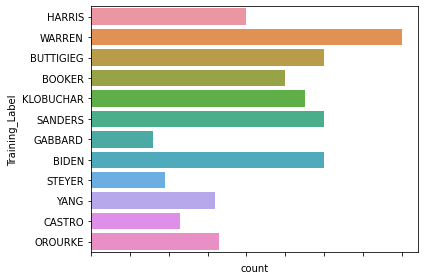

In [244]:
ax = sns.countplot(y='Training_Label',data=train_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()